In [196]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

###### Fixing random seed ######

seed = 3
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

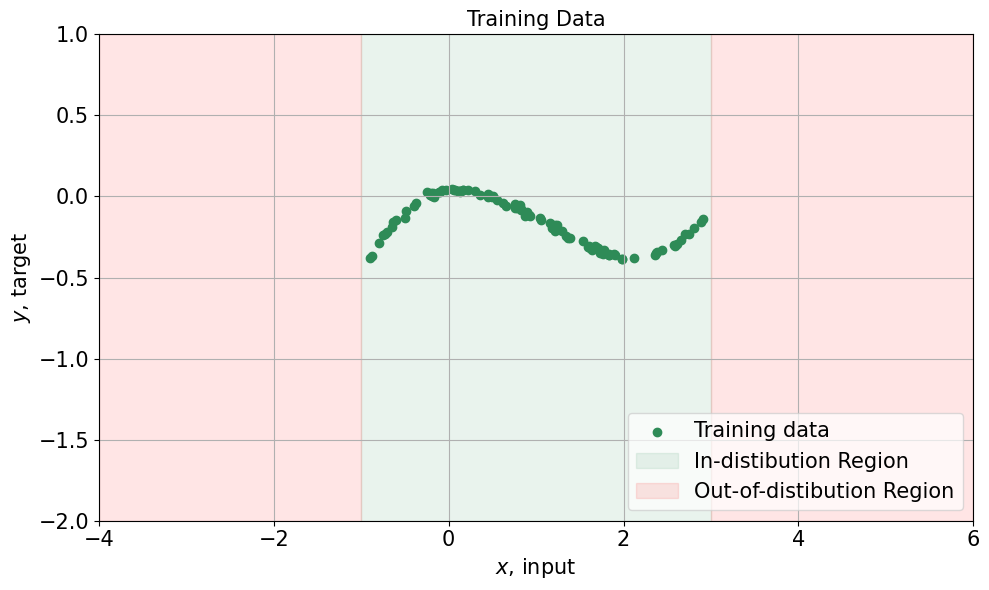

In [197]:
###### Generate Data ######

def polynom(X):
  return 0 + X + -5 * X**2 + 1.5*X ** 3

def generate(N=1000):
  X = np.random.uniform(-1, 3, N)
  Y = 0 + X + -5 * X**2 + 1.5*X ** 3
  Y += np.random.randn(Y.shape[0]) / 5
  return torch.tensor(X).float()[:, None], torch.tensor(Y)[:, None].float()

X_data, Y_data = generate(100)
Y_data += 3.5
Y_data /= 15

scale = 1
Y_data *= scale

Y_data -= 0.2

###### Data Visualization ######

plt.figure(figsize=(10, 6))
plt.scatter(X_data, Y_data, color="seagreen", label="Training data")

plt.fill_between([-1, 3], -2, 1, color='seagreen', alpha=0.1, label="In-distibution Region")
plt.fill_between([-4, -1], -2, 1, color='red', alpha=0.1, label="Out-of-distibution Region")
plt.fill_between([3, 6], -2, 1, color='red', alpha=0.1)

plt.ylabel("$y$, target", fontsize=15)
plt.xlabel("$x$, input", fontsize=15)
plt.title("Training Data", fontsize=15)

plt.legend(fontsize=15, loc='lower right', framealpha=0.7)

plt.xlim(-4, 6)
plt.ylim(-2, 1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

plt.grid()
plt.show()

In [198]:
###### ZigZag Model Architechture ######

A = -100 # constant for the "blank" zigzag input

class Net(torch.nn.Module):

  def __init__(self, hidden_layer=100):
    super().__init__()

    self.hidden_layer = hidden_layer
    self.fc1 = torch.nn.Linear(2, hidden_layer) # modified first layer, 2 = 1 + 1 (input + target)
    self.fc2 = torch.nn.Linear(hidden_layer, hidden_layer)
    self.fc3 = torch.nn.Linear(hidden_layer, hidden_layer)
    self.fc4 = torch.nn.Linear(hidden_layer, hidden_layer)
    self.fc5 = torch.nn.Linear(hidden_layer, hidden_layer)
    self.fc6 = torch.nn.Linear(hidden_layer, 1)
    self.activation = torch.nn.ELU()

  def forward(self, x, y=None):

    # adding second argument, either "blank" or target
    if y is None:
      x = torch.concat([x, A * torch.ones([x.shape[0], 1])], dim=1)
    else:
      x = torch.concat([x, y], dim=1)

    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.activation(self.fc3(x))
    x = self.activation(self.fc4(x))
    x = self.activation(self.fc5(x))
    x = self.fc6(x)

    return x

###### ZigZag's Optimization Step ######

def step(epoch, model, optimizer, criterion, X_data, Y_data):

    model.train()
    optimizer.zero_grad()

    # redefining inputs, adding second argument
    X_t = torch.cat([X_data, X_data])
    Y_inputs = Y_data
    Y_t = torch.cat([A * torch.ones_like(Y_data), Y_inputs])

    # updating loss function, adding second argument
    pred  = network(X_t, Y_t)
    loss = criterion(pred, torch.cat([Y_inputs, Y_inputs]))

    loss.backward()
    optimizer.step()

    return loss.item()

In [199]:
epochs = 1500
learning_rate = 0.01

###### ZigZag Training ######

network = Net(hidden_layer=8)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

network.train()
for epoch in range(epochs):
    step(epoch, network, optimizer, criterion, X_data, Y_data)

###### ZigZag Inference ######
network.eval()

X_min, X_max = -7, 8
Xt = torch.linspace(X_min, X_max, 100)[:, None]

Y_1 = network(Xt)
Y_1 = Y_1.detach()

Y_2 = network(Xt, Y_1)
Y_2 = Y_2.detach()

# compute reconstruction error / uncertainty
error = torch.linalg.norm(Y_1 - Y_2, dim=1).detach()

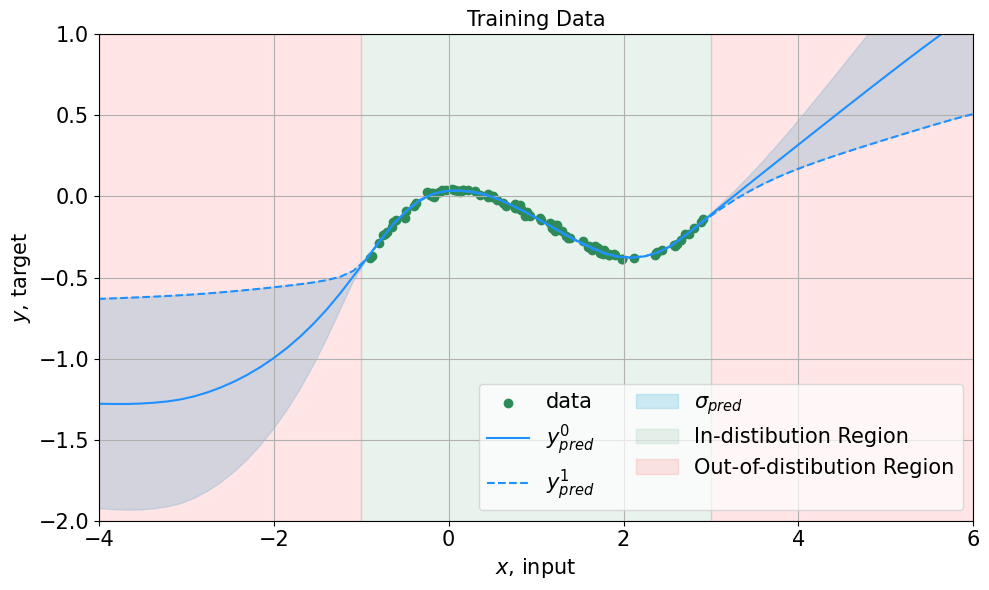

In [203]:
###### Visualize Final Result ######

plt.figure(figsize=(10, 6))
plt.scatter(X_data, Y_data, label="data", color="seagreen")
plt.plot(Xt, Y_1, c="dodgerblue", label="$y^{0}_{pred}$")
plt.plot(Xt, Y_2, c="dodgerblue", label="$y^{1}_{pred}$", linestyle="--")
plt.fill_between(Xt[:, 0], Y_1[:, 0] - error, Y_1[:, 0] + error, alpha=0.4, color="skyblue", label="$\sigma_{pred}$")

plt.fill_between([-1, 3], -2, 1, color='seagreen', alpha=0.1, label="In-distibution Region")
plt.fill_between([-4, -1], -2, 1, color='red', alpha=0.1, label="Out-of-distibution Region")
plt.fill_between([3, 6], -2, 1, color='red', alpha=0.1)

plt.xlim(-4, 6)
plt.ylim(-2, 1)

plt.ylabel("$y$, target", fontsize=15)
plt.xlabel("$x$, input", fontsize=15)
plt.title("Training Data", fontsize=15)

plt.grid()
plt.legend(fontsize=15, ncol=2, loc='lower right', framealpha=0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()